<img src="images/aaib.PNG" style="width:400px;height:250px;">

## Machine Learning: Hello World (Regressor version)!

#### The major task here is to predict median house values in Californian districts, given features from these districts

#### Dataset and coding inspiration used here can be found at: Géron, A. (2017). Hands-on machine learning with scikit-learn and tensorflow: Concepts. Tools, and Techniques to build intelligent systems.

# Setup

In [1]:
# Commonly used libraries
import numpy as np
import pandas as pd
import os

# From scikitlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# to keep stability
np.random.seed(42)

# To plot 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Loading  and Overview of the Data 

In [2]:
housing = pd.read_csv('dataset/housing.csv')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


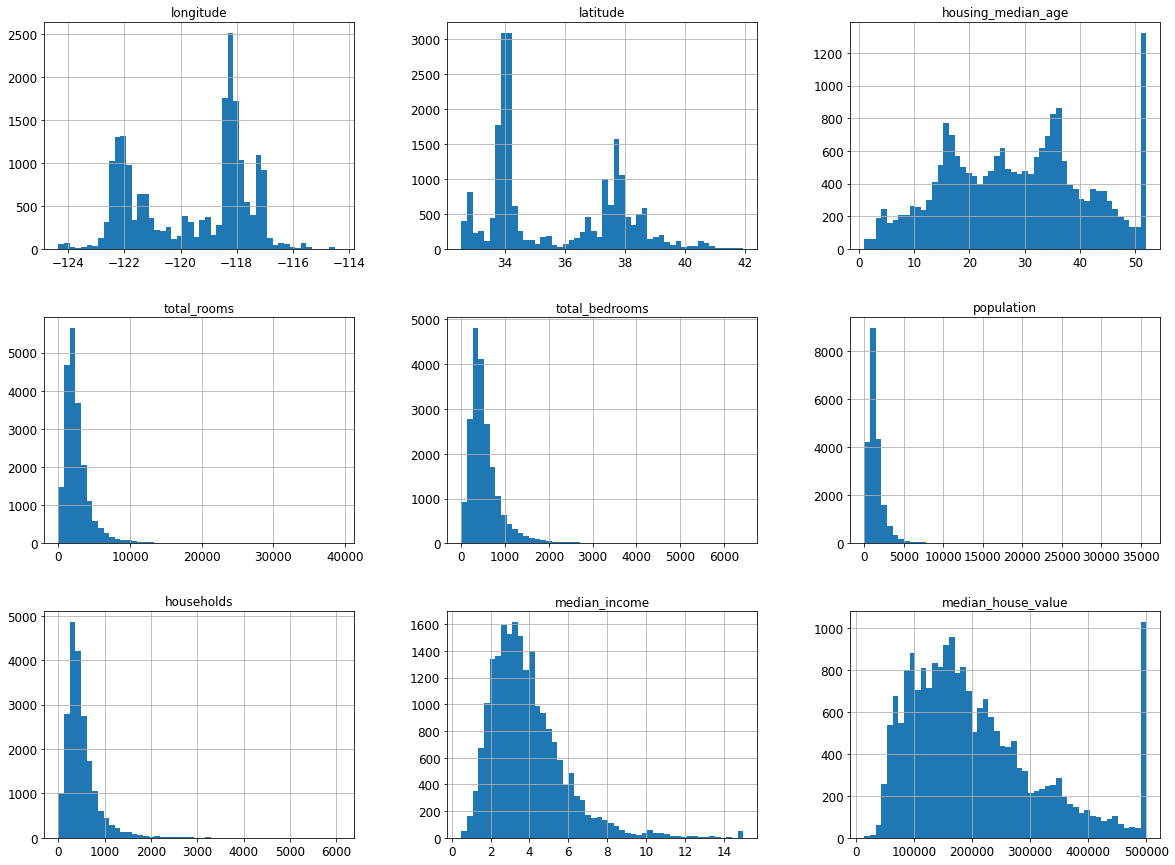

In [7]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# 1. Feature Engineering: Creating Interaction Features

housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [9]:
## For illustration only. Sklearn has train_test_split()

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#### We will use the scikit learn option, but keep in mind that probably the best solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier)

#### Also, So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. 

In [10]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [11]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND,4.192201,NaN,3.877437
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND,5.039384,NaN,2.679795
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY,3.977155,NaN,1.360332
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN,6.163636,NaN,3.444444
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN,5.492991,NaN,2.483645


### Now, we suppose experts in real estate have said that median income is very important in predicting house price, so we need to create categories for the continous variable we have

### We can check if it is worthy to split train and test based on this variable then...

<AxesSubplot:>

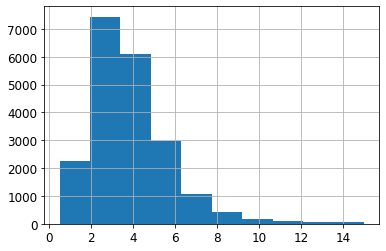

In [12]:
housing["median_income"].hist()

#### The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [13]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 0)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [14]:
housing["income_cat"].value_counts()

5.0    20640
Name: income_cat, dtype: int64

<AxesSubplot:>

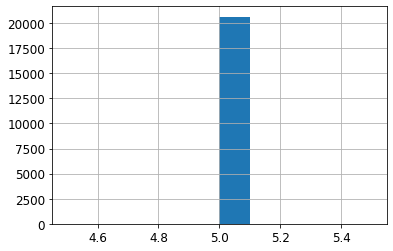

In [15]:
housing["income_cat"].hist()

In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
# we can look at the income category proportions in the test set and then in the full housing dataset

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

5.0    1.0
Name: income_cat, dtype: float64

In [18]:
housing["income_cat"].value_counts() / len(housing)

5.0    1.0
Name: income_cat, dtype: float64

# Discover and visualize the data to gain insights

#### This phase can be very long, it needs to be done well, and in this very first example we will not focus on this part. Instead, In Lecture 2, we will play a bit more with Data PreProcessing Treatments

In [19]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

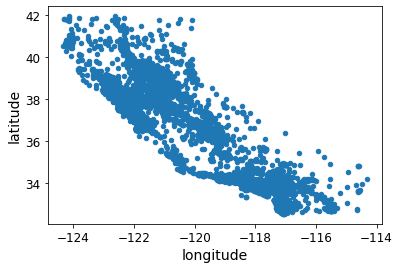

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

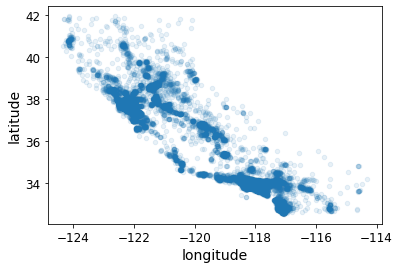

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


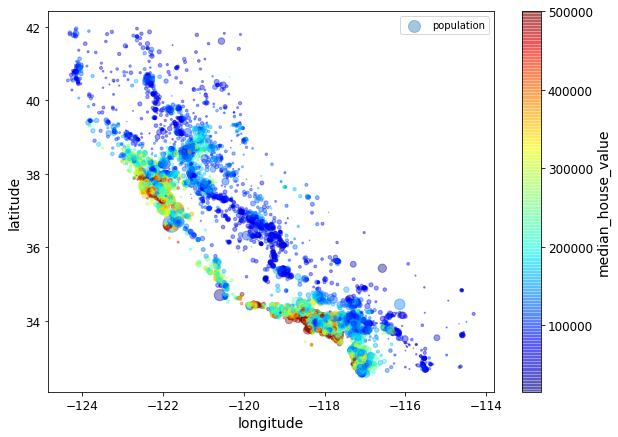

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [23]:
corr_matrix = housing.corr()

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.689752
rooms_per_household         0.157999
total_rooms                 0.136167
housing_median_age          0.107050
households                  0.068976
total_bedrooms              0.052690
population                 -0.024618
population_per_household   -0.027295
longitude                  -0.041830
latitude                   -0.148438
bedrooms_per_room          -0.255375
income_cat                       NaN
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

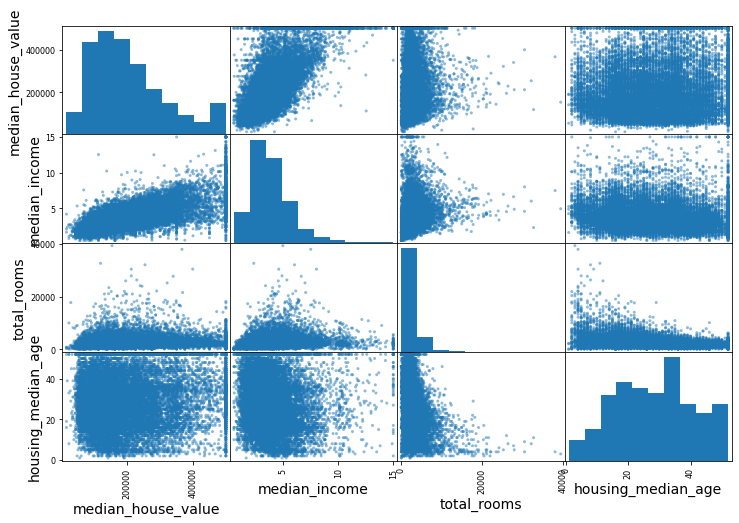

In [25]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

## DPT - Data Preprocessing Treatments
2. Feature Selection: Removing Highly Correlated Features


In [26]:
# Correlation matrix
corr_matrix = housing.corr()

# Remove highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_correlation = [column for column in upper.columns if any(upper[column] > 0.9)]

housing = housing.drop(columns=high_correlation)


# Prepare the data for Machine Learning algorithms

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [28]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
17973,-121.95,37.31,27.0,4140.0,NaN,2135.0,893.0,3.6292,<1H OCEAN,4.636058,NaN,2.390817,5.0
3354,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND,5.923503,NaN,2.774945,5.0
4600,-118.27,34.04,13.0,1784.0,NaN,2158.0,682.0,1.7038,<1H OCEAN,2.615836,NaN,3.164223,5.0
6814,-118.07,34.10,32.0,4275.0,NaN,2812.0,1012.0,3.3512,<1H OCEAN,4.224308,NaN,2.778656,5.0
11512,-118.10,33.74,32.0,2035.0,NaN,934.0,512.0,4.2287,NEAR OCEAN,3.974609,NaN,1.824219,5.0


In [29]:
# option 1 - to drop missing values
#sample_incomplete_rows.dropna(subset=["total_bedrooms"])    

In [30]:
# option 2 - to drop missing values
#sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

In [31]:
# option 3 - fill nan with median in specific column
#median = housing["total_bedrooms"].median()
#sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) 
#sample_incomplete_rows

In [32]:
# option 4 - use imputer in the whole data, but we need to revome categorical feature (missing) before, 
# because it will only work on numerical data

imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [33]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [34]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
11604,-118.01,33.79,23.0,2663.0,430.0,1499.0,403.0,5.7837,6.607940,0.161472,3.719603,5.0
10897,-117.84,33.73,20.0,2572.0,732.0,1534.0,669.0,2.4211,3.844544,0.284603,2.292975,5.0
12076,-117.60,33.87,15.0,7626.0,1570.0,3823.0,1415.0,3.4419,5.389399,0.205875,2.701767,5.0
13277,-117.64,34.09,34.0,2839.0,659.0,1822.0,631.0,3.0500,4.499208,0.232124,2.887480,5.0
308,-122.18,37.77,51.0,2107.0,471.0,1173.0,438.0,3.2552,4.810502,0.223541,2.678082,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12528,-121.49,38.56,35.0,1521.0,457.0,987.0,455.0,1.9013,3.342857,0.300460,2.169231,5.0
5642,-118.31,33.74,36.0,2464.0,472.0,1111.0,457.0,4.5074,5.391685,0.191558,2.431072,5.0
8763,-118.37,33.81,33.0,5057.0,790.0,2021.0,748.0,6.8553,6.760695,0.156219,2.701872,5.0
941,-122.03,37.54,16.0,4458.0,856.0,3038.0,870.0,5.0739,5.124138,0.192014,3.491954,5.0


In [35]:
# imputer(housing_num).fit
# change:
imputer.fit(housing_num)


# The imputer has simply computed the median of each attribute and stored the result in its statistics_ 
# instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that 
# there won’t be any missing values in new data after the system goes live, so it is safer to 
# apply the imputer to all the numerical attributes

SimpleImputer(strategy='median')

In [36]:
imputer.statistics_

array([-1.18490000e+02,  3.42550000e+01,  2.90000000e+01,  2.12300000e+03,
        4.33000000e+02,  1.16500000e+03,  4.09000000e+02,  3.53485000e+00,
        5.22679628e+00,  2.03144654e-01,  2.81690895e+00,  5.00000000e+00])

Check that this is the same as manually computing the median of each attribute:

In [37]:
housing_num.median().values

array([-1.18490000e+02,  3.42550000e+01,  2.90000000e+01,  2.12300000e+03,
        4.33000000e+02,  1.16500000e+03,  4.09000000e+02,  3.53485000e+00,
        5.22679628e+00,  2.03144654e-01,  2.81690895e+00,  5.00000000e+00])

In [38]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
11604,-118.01,33.79,23.0,2663.0,430.0,1499.0,403.0,5.7837,6.607940,0.161472,3.719603,5.0
10897,-117.84,33.73,20.0,2572.0,732.0,1534.0,669.0,2.4211,3.844544,0.284603,2.292975,5.0
12076,-117.60,33.87,15.0,7626.0,1570.0,3823.0,1415.0,3.4419,5.389399,0.205875,2.701767,5.0
13277,-117.64,34.09,34.0,2839.0,659.0,1822.0,631.0,3.0500,4.499208,0.232124,2.887480,5.0
308,-122.18,37.77,51.0,2107.0,471.0,1173.0,438.0,3.2552,4.810502,0.223541,2.678082,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12528,-121.49,38.56,35.0,1521.0,457.0,987.0,455.0,1.9013,3.342857,0.300460,2.169231,5.0
5642,-118.31,33.74,36.0,2464.0,472.0,1111.0,457.0,4.5074,5.391685,0.191558,2.431072,5.0
8763,-118.37,33.81,33.0,5057.0,790.0,2021.0,748.0,6.8553,6.760695,0.156219,2.701872,5.0
941,-122.03,37.54,16.0,4458.0,856.0,3038.0,870.0,5.0739,5.124138,0.192014,3.491954,5.0


Transform the training set:

In [39]:
# we use the “trained” imputer to transform the training set by replacing missing values by the learned medians:
X = imputer.transform(housing_num)

# The result is a plain Numpy array containing the transformed features. If you want to put it back into 
# a Pandas DataFrame, it’s simple:

In [40]:
X

array([[-118.01      ,   33.79      ,   23.        , ...,    0.16147202,
           3.71960298,    5.        ],
       [-117.84      ,   33.73      ,   20.        , ...,    0.28460342,
           2.29297459,    5.        ],
       [-117.6       ,   33.87      ,   15.        , ...,    0.20587464,
           2.70176678,    5.        ],
       ...,
       [-118.37      ,   33.81      ,   33.        , ...,    0.1562191 ,
           2.70187166,    5.        ],
       [-122.03      ,   37.54      ,   16.        , ...,    0.19201436,
           3.49195402,    5.        ],
       [-118.32      ,   34.09      ,   44.        , ...,    0.20314465,
           3.16391185,    5.        ]])

In [41]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = list(housing.index.values))
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
11604,-118.01,33.79,23.0,2663.0,430.0,1499.0,403.0,5.7837,6.607940,0.161472,3.719603,5.0
10897,-117.84,33.73,20.0,2572.0,732.0,1534.0,669.0,2.4211,3.844544,0.284603,2.292975,5.0
12076,-117.60,33.87,15.0,7626.0,1570.0,3823.0,1415.0,3.4419,5.389399,0.205875,2.701767,5.0
13277,-117.64,34.09,34.0,2839.0,659.0,1822.0,631.0,3.0500,4.499208,0.232124,2.887480,5.0
308,-122.18,37.77,51.0,2107.0,471.0,1173.0,438.0,3.2552,4.810502,0.223541,2.678082,5.0


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [42]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
11604,<1H OCEAN
10897,<1H OCEAN
12076,INLAND
13277,INLAND
308,NEAR BAY
7959,<1H OCEAN
11048,<1H OCEAN
18812,INLAND
13782,INLAND
17722,<1H OCEAN


In [43]:
# One option is to use OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [1.],
       [1.],
       [3.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [44]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [45]:
from sklearn.preprocessing import OneHotEncoder
# needed to be imported

# Another option is to use OneHotEncoder


cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [46]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [47]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

In [48]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## DPT - Data Preprocessing Treatments
1. Feature Engineering: Creating Interaction Features

Interaction features can capture relationships between existing features that may not be obvious when considered in isolation. These features can provide additional predictive power to your models.

In [49]:
# Interaction features: Creating new features based on interactions
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [51]:
housing_num_tr

array([[ 0.77738183, -0.86037145, -0.44938232, ..., -0.89020113,
         0.0586127 ,  0.        ],
       [ 0.86236206, -0.88850205, -0.68766751, ...,  1.24144131,
        -0.07186714,  0.        ],
       [ 0.98233415, -0.82286399, -1.08480949, ..., -0.12150605,
        -0.03447889,  0.        ],
       ...,
       [ 0.5974237 , -0.85099458,  0.34490165, ..., -0.98113935,
        -0.0344693 ,  0.        ],
       [-1.23215067,  0.89779089, -1.0053811 , ..., -0.36145433,
         0.03779186,  0.        ],
       [ 0.62241788, -0.71971846,  1.21861402, ..., -0.16876737,
         0.00778903,  0.        ]])

In [52]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [53]:
housing_prepared

array([[ 0.77738183, -0.86037145, -0.44938232, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86236206, -0.88850205, -0.68766751, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.98233415, -0.82286399, -1.08480949, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5974237 , -0.85099458,  0.34490165, ...,  0.        ,
         0.        ,  1.        ],
       [-1.23215067,  0.89779089, -1.0053811 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.62241788, -0.71971846,  1.21861402, ...,  0.        ,
         0.        ,  0.        ]])

In [54]:
housing_prepared.shape

(16512, 17)

# Select and train a model 

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [56]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [268731.22015801 182625.77749163 164030.22969487 144646.95903807
 230358.20633143]


Compare against the actual values:

In [57]:
print("Labels:", list(some_labels))

Labels: [258000.0, 175000.0, 138100.0, 121300.0, 120100.0]


In [58]:
some_data_prepared

array([[ 0.77738183, -0.86037145, -0.44938232,  0.01512161, -0.25084292,
         0.06951411, -0.24994671,  1.008984  ,  0.52233735, -0.89020113,
         0.0586127 ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.86236206, -0.88850205, -0.68766751, -0.02655512,  0.47227071,
         0.101068  ,  0.44922658, -0.76434076, -0.68908269,  1.24144131,
        -0.07186714,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.98233415, -0.82286399, -1.08480949,  2.28810667,  2.47879133,
         2.16469254,  2.41006597, -0.22600438, -0.01184776, -0.12150605,
        -0.03447889,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.96233881, -0.71971846,  0.42433005,  0.09572717,  0.29747835,
         0.36071146,  0.34934468, -0.43267956, -0.40209075,  0.33292089,
        -0.01749349,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        

In [59]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67237.53497960277

In [60]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

48730.530582716645

In [61]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [62]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fine-tune your model

In [63]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [64]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69337.59728853 72843.01431449 68060.62867362 74961.61004583
 72525.90748648 72662.02787661 70448.66182666 67678.29203402
 71170.48994193 70327.68724343]
Mean: 71001.59167316105
Standard deviation: 2177.246801108526


In [65]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67538.87977679 68490.90941635 63235.79801971 66804.82545264
 67577.16253726 67109.2659827  68371.62998591 67679.38213621
 70012.8776879  67233.90860294]
Mean: 67405.46395984112
Standard deviation: 1640.0192522684176


In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) 
    {'max_features': [2, 3, 4]},
  ]

tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

# RMSE for grid search
grid_search_rmse = np.sqrt(-grid_search.best_score_)


The best hyperparameter combination found:

In [67]:
grid_search.best_params_

{'max_features': 8}

In [68]:
grid_search.best_estimator_

DecisionTreeRegressor(max_features=8, random_state=42)

In Lecture 1, we used GridSearch to find the best hyperparameters to predict housing prices. In this task, you should search and list other commonly used algorithms to define hyperparameters, pick two, and implement/replace GridSearch in the lecture 1’ notebook. Then, you should collect, contrast, and analyze the results.

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the model
tree_reg = DecisionTreeRegressor(random_state=42)

# Define the parameter space
param_distributions = {
    'max_features': [2, 3, 4, 6, 8],
    'max_depth': [10, 20, 30, None],  # Added additional parameter to tune
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the random search with cross-validation
random_search = RandomizedSearchCV(estimator=tree_reg,
                                   param_distributions=param_distributions,
                                   n_iter=100,  # Number of parameter settings sampled
                                   cv=5, verbose=2, random_state=42, n_jobs=-1,scoring='neg_mean_squared_error')

# Fit the random search model
random_search.fit(housing_prepared, housing_labels)

print("Best parameters found: ", random_search.best_params_)
print("Best MSE from Random Search:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 8, 'max_depth': 10}
Best MSE from Random Search: -3772347249.1105127


In [70]:
if random_search.best_score_ is not None:
    random_search_rmse = np.sqrt(-random_search.best_score_)
    print("Confirmed RMSE from Random Search:", random_search_rmse)
else:
    print("Random Search failed to provide a valid MSE.")


Confirmed RMSE from Random Search: 61419.43706279399


Bayesian Optimization Implementation

In [71]:
!pip install bayesian-optimization


In [72]:
from bayes_opt import BayesianOptimization
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def dt_cv(max_features, max_depth, min_samples_split, min_samples_leaf):
    estimator = DecisionTreeRegressor(
        max_features=int(max_features),
        max_depth=int(max_depth) if max_depth else None,
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    cval = cross_val_score(estimator, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=5)
    return cval.mean()

# Bounded region of parameter space
pbounds = {
    'max_features': (2, 8),
    'max_depth': (10, 50),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

optimizer = BayesianOptimization(
    f=dt_cv,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=10,
    n_iter=30,
)


# print the best score from the bayesian optimization
best_neg_mse = optimizer.max['target']

# Calculate RMSE
rmse = np.sqrt(-best_neg_mse)
print("RMSE from Bayesian Optimization:", rmse)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | -4.818e+0 | 26.68     | 6.322     | 1.0       | 4.419     |
| 2         | -5.56e+09 | 15.87     | 2.554     | 1.559     | 4.764     |
| 3         | -4.312e+0 | 25.87     | 5.233     | 2.258     | 7.482     |
| 4         | -4.719e+0 | 18.18     | 7.269     | 1.082     | 7.364     |
| 5         | -5e+09    | 26.69     | 5.352     | 1.421     | 3.585     |
| 6         | -4.729e+0 | 42.03     | 7.81      | 1.94      | 7.539     |
| 7         | -5.05e+09 | 45.06     | 7.368     | 1.255     | 2.312     |
| 8         | -4.398e+0 | 16.79     | 7.269     | 1.295     | 5.369     |
| 9         | -4.342e+0 | 48.32     | 5.199     | 3.076     | 4.524     |
| 10        | -4.58e+09 | 37.46     | 7.008     | 1.055     | 8.001     |
| 11        | -4.567e+0 | 25.75     | 6.156     | 1.986     | 8.942     |
| 12        | -4.555e+0 | 25.51     | 

Let's look at the score of each hyperparameter combination tested during the grid search:

In [73]:
# Assuming `random_search` is your RandomizedSearchCV object
best_random_search_score = random_search.best_score_
random_search_rmse = np.sqrt(-best_random_search_score)
print("RMSE from Random Search:", random_search_rmse)
print("RMSE from Bayesian Optimization:", rmse)
print("RMSE from Grid Search:", grid_search_rmse)

RMSE from Random Search: 61419.43706279399
RMSE from Bayesian Optimization: 60823.40038726432
RMSE from Grid Search: 71485.44089841515


In [74]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

81802.30633207592 {'max_features': 2}
75770.52614184337 {'max_features': 4}
72058.16489033127 {'max_features': 6}
71485.44089841515 {'max_features': 8}
81802.30633207592 {'max_features': 2}
76697.75697666238 {'max_features': 3}
75770.52614184337 {'max_features': 4}


In [75]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.043521,0.002309,0.002198,0.000290,2,{'max_features': 2},-7.107534e+09,-6.453654e+09,-6.501036e+09,-6.749459e+09,...,-6.691617e+09,2.329482e+08,6,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,0.052284,0.004223,0.001844,0.000429,4,{'max_features': 4},-6.131109e+09,-5.347133e+09,-5.883663e+09,-6.201699e+09,...,-5.741173e+09,4.238876e+08,3,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,0.074544,0.002688,0.001981,0.000261,6,{'max_features': 6},-5.451444e+09,-4.889010e+09,-5.169555e+09,-5.649101e+09,...,-5.192379e+09,3.225044e+08,2,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,0.084828,0.003176,0.001363,0.000436,8,{'max_features': 8},-5.194624e+09,-4.682751e+09,-5.125534e+09,-5.286955e+09,...,-5.110168e+09,2.209305e+08,1,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4,0.032613,0.001764,0.001699,0.000403,2,{'max_features': 2},-7.107534e+09,-6.453654e+09,-6.501036e+09,-6.749459e+09,...,-6.691617e+09,2.329482e+08,6,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
5,0.039786,0.002646,0.001887,0.000458,3,{'max_features': 3},-5.841683e+09,-5.845685e+09,-5.896859e+09,-5.954347e+09,...,-5.882546e+09,4.113203e+07,5,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
6,0.049534,0.003030,0.001569,0.000459,4,{'max_features': 4},-6.131109e+09,-5.347133e+09,-5.883663e+09,-6.201699e+09,...,-5.741173e+09,4.238876e+08,3,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


In [76]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [77]:
final_rmse

70618.04343109381

We can compute a 95% confidence interval for the test RMSE:

In [78]:
from scipy import stats

In [79]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([67699.86132963, 73420.33023639])

We could compute the interval manually like this:

In [80]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(67699.8613296312, 73420.33023638895)

Alternatively, we could use a z-scores rather than t-scores:

In [81]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(67700.7356081747, 73419.52406672036)

In [82]:
# Prepare the data for Machine Learning algorithms
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

# Handle Missing Values
housing_num = housing.drop('ocean_proximity', axis=1)
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
housing_num_tr = imputer.transform(housing_num)
housing_tr = pd.DataFrame(housing_num_tr, columns=housing_num.columns, index=housing.index)

# Encode Categorical Variables
housing_cat = housing[['ocean_proximity']]
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot_df = pd.DataFrame(housing_cat_1hot, columns=cat_encoder.categories_[0], index=housing.index)

# Combine Numerical and Categorical Features
housing_prepared = pd.concat([housing_tr, housing_cat_1hot_df], axis=1)




# Additional ML Algorithms
## Random Forest Regressor:

In [83]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg.fit(housing_prepared, housing_labels)
rf_predictions = rf_reg.predict(housing_prepared)
rf_rmse = np.sqrt(mean_squared_error(housing_labels, rf_predictions))
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 18546.441612050065


## Gradient Boosting Regressor:


In [84]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor()
gb_reg.fit(housing_prepared, housing_labels)
gb_predictions = gb_reg.predict(housing_prepared)
gb_rmse = np.sqrt(mean_squared_error(housing_labels, gb_predictions))
print("Gradient Boosting RMSE:", gb_rmse)


Gradient Boosting RMSE: 50274.426200878814


## Support Vector Machine Regressor:

In [85]:
from sklearn.svm import SVR

svr_reg = SVR()
svr_reg.fit(housing_prepared, housing_labels)
svr_predictions = svr_reg.predict(housing_prepared)
svr_rmse = np.sqrt(mean_squared_error(housing_labels, svr_predictions))
print("Support Vector Regressor RMSE:", svr_rmse)


Support Vector Regressor RMSE: 118252.2563496394


# Doubling / Halving the features

In [86]:
# Separate target variable
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Handle Missing Values
housing_num = housing.drop('ocean_proximity', axis=1)
imputer = SimpleImputer(strategy="median")
housing_num_tr = imputer.fit_transform(housing_num)
housing_tr = pd.DataFrame(housing_num_tr, columns=housing_num.columns, index=housing.index)

# Encode Categorical Variables
housing_cat = housing[['ocean_proximity']]
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot_df = pd.DataFrame(housing_cat_1hot, columns=cat_encoder.categories_[0], index=housing.index)

# Combine Numerical and Categorical Features
housing_prepared = pd.concat([housing_tr, housing_cat_1hot_df], axis=1)


In [91]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
housing_poly = poly.fit_transform(housing_prepared)

# Convert to DataFrame for easier handling
housing_poly_df = pd.DataFrame(housing_poly, columns=poly.get_feature_names(housing_prepared.columns))
X_double = housing_poly_df


In [92]:
import random

# Randomly select half of the features
original_features = list(housing_prepared.columns)
reduced_features = random.sample(original_features, len(original_features) // 2)
X_half = housing_prepared[reduced_features]


In [94]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()

    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    processing_time = end_time - start_time

    return mse, r2, processing_time

# Double features
mse_double, r2_double, time_double = train_and_evaluate(X_double, housing_labels)

# Half features
mse_half, r2_half, time_half = train_and_evaluate(X_half, housing_labels)

print("Double Features Metrics:\nMSE: ", mse_double, "\nR2 Score: ", r2_double, "\nProcessing Time: ", time_double)
print("\nHalf Features Metrics:\nMSE: ", mse_half, "\nR2 Score: ", r2_half, "\nProcessing Time: ", time_half)


Double Features Metrics:
MSE:  53517659843.89042 
R2 Score:  -3.1174783213876873 
Processing Time:  0.18309807777404785

Half Features Metrics:
MSE:  5195446960.705969 
R2 Score:  0.6002788557454366 
Processing Time:  0.002545595169067383


# Pipeline

In [96]:
# Separate numerical and categorical columns
num_attribs = list(housing.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# Full pipeline for both numerical and categorical attributes
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)


In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(housing_prepared, housing_labels, test_size=0.2, random_state=42)

# Train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions
y_pred = lin_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE: ", mse)
print("R2 Score: ", r2)


MSE:  4530316161.348168
R2 Score:  0.6514519013388278
